<a href="https://colab.research.google.com/github/ronalds82/Datu-kopas-tulkosana/blob/main/SQuAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Autors: *Ronalds Turnis, rt20018*
===========================


# Globālie mainīgie

In [ ]:
INSTALL = False # True, ja videi ir nepieciešamas papildus instalācijas
CLOUD = False # True, ja netiek izmantots lokālais GPU
TRAIN = False  # True, ja modelim ir nepieciešama satura regulēšana
FINE_TUNED = False # True, ja testējam pašu saglabātu modeli
CHAT = False # True, ja vēlamies ieslēgt tērzētavu ar modeli
FLATTEN = True # True, ja ir nepieciešama SQuAD datu kopas "saspiešana"

weights_dir = './weights' # Tiek glabāti modeļa svari
logs_dir = './logs' # Tiek glabāta notikumu informācija
tmp_dir = './tmp_trainer' # Glabājās pagaidu informācija

# Jānorāda, ja vēlamies veikt pašu saglabāta modeļa novērtēšanu
model_link = 'https://www.dropbox.com/scl/fi/cguiqykr0jlp1yj6mi7rm/modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu&dl=0'
model_weight_file = 'modelis.pth?rlkey=m7oeyaev1pt0x1c5u2kdnl0bu'

# SQUAD testēšanai nepieciešamie mainīgie
data_files = {'train': 'train-v1.1.LV.json', 'validation': 'train-v1.1.LV.json'}
flattened_ENG_train_file = 'flattened_train-v2.0.json'
flattened_ENG_val_file = 'flattened_val-v2.0.json'
flattened_LV_train_file = 'flattened_train-v2.0.LV.json'
flattened_LV_val_file = 'flattened_val-v2.0.LV.json'
flattened_data_files = {'train': flattened_ENG_train_file, 'validation': flattened_ENG_val_file}

max_length = 384 # Maksimālais garums context un question string tipa mainīgajiem
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

# Moduļu importēšana

In [ ]:
# Ja ir nepieciešamas papildus instalācijas
if INSTALL:
    !pip install datasets
    !pip install ipyfilechooser
    !pip install transformers[torch] -U
    !pip install accelerate -U
    !pip install rouge_score
    !pip install evaluate

# Importējam nepieciešamos moduļus
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import evaluate
import json
import collections
from tqdm import tqdm, tqdm_notebook
from transformers import Trainer, TrainingArguments, IntervalStrategy, DataCollatorForLanguageModeling, trainer_utils
from transformers import default_data_collator, AutoTokenizer, AutoModelForQuestionAnswering, tokenization_utils_base
from sklearn.model_selection import train_test_split
from google.colab import files
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from ipyfilechooser import FileChooser
from datasets import load_dataset, arrow_dataset
from torch.nn import CrossEntropyLoss
from pathlib import Path

# Modeļa un tokenizera inicializācija

In [ ]:
print("Ielādējam modeli un tokenizeru...")

model = AutoModelForQuestionAnswering.from_pretrained('bert-base-cased')
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Iestatām padding tokenu, ja tā nav
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Modelis un tokenizeris inicializēts!")
print("Izmantotā ierīce:", device)

Ielādējam modeli un tokenizeru...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelis un tokenizeris inicializēts!
Izmantotā ierīce: cuda


# Iepriekšējo datu dzēšana

In [ ]:
# Pārbaudām vai eksistē ģenerētās direktorijas un dzēšam tās pirms modeļa trenēšanas, lai nekonfliktētu ar vecajiem datiem
def delete_directory(dir_path):
    try:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
            print(f"Direktorija dzēsta: {dir_path}")
        else:
            print(f"Direktorija neeksistē: {dir_path}")
    except Exception as e:
        print(f"Kļūda dzēšot direktoriju: {e}")

delete_directory(weights_dir)
delete_directory(logs_dir)
delete_directory(tmp_dir)

# Izdzēšam GPU kešatmiņu
torch.cuda.empty_cache()

Direktorija neeksistē: ./weights
Direktorija neeksistē: ./logs
Direktorija dzēsta: ./tmp_trainer


# Datu inicializācija

In [ ]:
class SquadDatasetFlat():
    def __init__(self,
                 path_to_json_file: str,
                 checkpoint_path: str,
                 train_file: str,
                 val_file: str) -> None:
        self.path_to_json_file = path_to_json_file
        self.checkpoint_path = checkpoint_path

        self.train_file = train_file
        self.val_file = val_file

        self.data = self.load_data()

    def load_data(self):
        with open(self.path_to_json_file, 'r') as f:
            train_data = json.load(f)
        print(f'Flattening SQUAD {train_data["version"]}')
        train_data_flat, val_data_flat, errors = self.load_squad_data(train_data)
        print(f'\nErroneous Datapoints: {errors}')

        with open(Path(self.checkpoint_path) / Path(self.train_file), 'w') as file:
            train_data = {'data':train_data_flat}
            file.write(json.dumps(train_data))
            file.close()

        with open(Path(self.checkpoint_path) / Path(self.val_file), 'w') as file:
            val_data = {'data':val_data_flat}
            file.write(json.dumps(val_data))
            file.close()

    def load_squad_data(self, data, split=0.2):
        errors = 0
        flattened_data_train = []
        flattened_data_val = []

        train_range = len(data['data']) - (len(data['data']) * split)

        for i, article in enumerate(data["data"]):
            title = article.get("title", "").strip()
            for paragraph in article["paragraphs"]:
                context = paragraph["context"].strip()
                for qa in paragraph["qas"]:
                    question = qa["question"].strip()
                    id_ = qa["id"]

                    answer_starts = [answer["answer_start"] for answer in qa["answers"]]
                    answers = [answer["text"].strip() for answer in qa["answers"]]

                    if i <= train_range:
                        flattened_data_train.append({"title": title,
                                                     "context": context,
                                                     "question": question,
                                                     "id": id_,
                                                     "answers": {
                                                         "answer_start": answer_starts,
                                                         "text": answers}
                                                     })
                    else:
                        flattened_data_val.append({"title": title,
                                                   "context": context,
                                                   "question": question,
                                                   "id": id_,
                                                   "answers": {
                                                       "answer_start": answer_starts,
                                                       "text": answers}
                                                   })

        return flattened_data_train, flattened_data_val, errors

def prepare_squad_dataset(examples: collections.OrderedDict or dict) -> tokenization_utils_base.BatchEncoding:
    pad_on_right = tokenizer.padding_side == "right"

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        # Check if answers are empty or answer_start is missing
        if not answers["answer_start"] or not answers["text"]:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
            continue

        start_char = answers["answer_start"][0]
        end_char = start_char + len(answers["text"][0])

        token_start_index = 0
        while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
            token_start_index += 1

        token_end_index = len(input_ids) - 1
        while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
            token_end_index -= 1

        if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                token_start_index += 1
            tokenized_examples["start_positions"].append(token_start_index - 1)

            while offsets[token_end_index][1] >= end_char:
                token_end_index -= 1
            tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

def prepare_validation_features(examples: collections.OrderedDict or dict) -> tokenization_utils_base.BatchEncoding:
    pad_on_right = tokenizer.padding_side == "right"

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples["offset_mapping"]

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)
        sequence_ids = tokenized_examples.sequence_ids(i)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if not answers["answer_start"] or not answers["text"]:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)

                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

# Sagatavojam datus
if FLATTEN:
    _ = SquadDatasetFlat(data_files['train'], '', flattened_ENG_train_file, flattened_ENG_val_file)
    _ = SquadDatasetFlat(data_files['validation'], '', flattened_LV_train_file, flattened_LV_val_file)

train_data = load_dataset("json", data_files=flattened_data_files['train'], field='data')
val_data = load_dataset("json", data_files=flattened_data_files['validation'], field='data')

train_dataset = train_data.map(prepare_squad_dataset, batched=True, remove_columns=train_data['train'].column_names)
val_dataset = val_data['train'].map(prepare_validation_features, batched=True, remove_columns=val_data['train'].column_names)

Flattening SQUAD v2.0

Erroneous Datapoints: 0
Flattening SQUAD v2.0

Erroneous Datapoints: 0


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/62857 [00:00<?, ? examples/s]

Map:   0%|          | 0/16233 [00:00<?, ? examples/s]

# Metriku aprēķināšanas funkcijas

In [ ]:
# Metriku vēsture
metrics_history = []

# Definējam izmantotās metrikas
metrics = {
  'squad': evaluate.load('squad')
}

def postprocess_qa_predictions(examples, features, raw_predictions, n_best_size=20, max_answer_length=30):
    all_start_logits, all_end_logits = raw_predictions
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)

    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    predictions = collections.OrderedDict()

    # Check dimensions
    print(f"Number of features: {len(features)}")
    print(f"Start logits length: {len(all_start_logits)}, End logits length: {len(all_end_logits)}")

    for example_index, example in enumerate(tqdm(examples)):
        feature_indices = features_per_example[example_index]
        valid_answers = []
        context = example["context"]

        for feature_index in feature_indices:
            # Check if feature_index is within the range
            if feature_index >= len(all_start_logits) or feature_index >= len(all_end_logits):
                print(f"Skipping feature_index {feature_index} as it's out of range.")
                continue

            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            offset_mapping = features[feature_index]["offset_mapping"]

            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]

            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

            for start_index in start_indexes:
                for end_index in end_indexes:
                    if (start_index >= len(offset_mapping) or end_index >= len(offset_mapping)
                        or offset_mapping[start_index] is None or offset_mapping[end_index] is None
                        or end_index < start_index or (end_index - start_index + 1) > max_answer_length):
                        continue

                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]
                    valid_answers.append({"score": start_logits[start_index] + end_logits[end_index],
                                          "text": context[start_char: end_char]})

        if valid_answers:
            best_answer = sorted(valid_answers, key=lambda x: x["score"], reverse=True)[0]
        else:
            best_answer = {"text": "", "score": 0.0}

        predictions[example["id"]] = best_answer["text"]

    return predictions

def compute_metrics(pred: trainer_utils.EvalPrediction) -> dict:
    # The Trainer hides the columns that are not used by the model (here example_id and offset_mapping which we will need for our post-processing), so we set them back
    val_dataset.set_format(type=val_dataset.format["type"], columns=list(val_dataset.features.keys()))

    # To get the final predictions we can apply our post-processing function to our raw predictions
    final_predictions = postprocess_qa_predictions(val_data['train'], val_dataset, pred.predictions)

    # We just need to format predictions and labels a bit as metric expects a list of dictionaries and not one big dictionary
    formatted_predictions = [{"id": k, "prediction_text": v} for k, v in final_predictions.items()]
    references = [{"id": ex["id"], "answers": ex["answers"]} for ex in val_data["train"]]

    # Hide again the columns that are not used by the model
    val_dataset.set_format(type=val_dataset.format["type"], columns=['attention_mask', 'end_positions', 'input_ids', 'start_positions'])
    results_squad = metrics['squad'].compute(predictions=formatted_predictions, references=references)

    print(results_squad)

    metrics_history.append(metric_results)

    return metric_results

# Funkcija, lai izvairītos no atmiņas problēmām
def preprocess_logits_for_metrics(logits, labels):
    if isinstance(logits, tuple):
        start_logits, end_logits = logits
    else:
        start_logits = logits.start_logits
        end_logits = logits.end_logits

    start_pred_ids = torch.argmax(start_logits, dim=-1)
    end_pred_ids = torch.argmax(end_logits, dim=-1)

    return (start_pred_ids, end_pred_ids), labels

# Modeļa trenēšana

In [ ]:
def train_model(model, train_dataset, val_dataset, output_dir):
    # Konfigurējam apmācības parametrus
    training_args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=3,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        evaluation_strategy=IntervalStrategy.STEPS,
        eval_steps=2500,
        warmup_steps=1000,
        weight_decay=0.001,
        learning_rate=1e-5,
        logging_dir=logs_dir,
        logging_steps=2500,
        save_strategy=IntervalStrategy.EPOCH,
        report_to="none",
        label_names=["start_positions", "end_positions"]
    )

    # Inicializējam traineri
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics = preprocess_logits_for_metrics,
        data_collator=default_data_collator
    )

    # Trenējam modeli
    trainer.train()
    return trainer

if TRAIN:
    trainer = train_model(model, train_dataset['train'], val_dataset, weights_dir)
else:
    # Inicializējam traineri validācijas dēļ
    trainer = Trainer(
        model=model,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
        preprocess_logits_for_metrics = preprocess_logits_for_metrics,
        data_collator=default_data_collator
    )

# Apmācīta modeļa analīze

In [ ]:
def plot_results(training_history):
    # Definējam sarakstus uzskaitei
    steps = []
    training_losses = []
    validation_losses = []

    # Ejam cauri katram ierakstam vēsturē
    for entry in training_history:
        if 'loss' in entry:  # Apmācības zaudējums
            steps.append(entry.get('step', len(steps) + 1))
            training_losses.append(entry['loss'])

        if 'eval_loss' in entry:  # Validācijas zaudējums
            validation_losses.append(entry['eval_loss'])

    # Izveidojam grafiku
    plt.figure(figsize=(12, 6))

    if training_losses:
        plt.plot(steps[:len(training_losses)], training_losses, label='Apmācības zaudējums', marker='o')

    if validation_losses:
        validation_steps = steps[:len(validation_losses)]
        plt.plot(validation_steps, validation_losses, label='Validācijas zaudējums', marker='x', linestyle='--')

    plt.xlabel('Soļu skaits')
    plt.ylabel('Zaudējums')
    plt.title('Apmācības un validācijas zaudējums apmācības laikā')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_metrics_history(metrics_history):
    epochs = list(range(1, len(metrics_history)+1))
    plt.figure(figsize=(12, 8))

    # Sagatavojam datus parādīšanai grafikā
    exact_match_scores = [x['exact_match'] for x in metrics_history]
    f1_scores = [x['f1'] for x in metrics_history]

    plt.plot(epochs, exact_match_scores, label='Exact Match', marker='o')
    plt.plot(epochs, f1_scores, label='F1', marker='o')

    plt.xlabel('Iterācija')
    plt.ylabel('Rezultāts')
    plt.title('Vērtēšanas metriku rezultāti atkarībā no iterācijas')
    plt.legend()
    plt.grid(True)
    plt.show()

# Izpildām tikai, ja ir notikusi modeļa pielāgošana, citādi tas tiks darīts "Saglabātā modeļa izmantošana" sadaļā
if TRAIN:
    plot_results(trainer.state.log_history)
    print()
    plot_metrics_history(metrics_history)

# Čatbota interfeiss

In [ ]:
def generate_text(model, tokenizer, input_text, max_length=150):
    # Tokenizējam ievadīto tekstu
    input_ids = tokenizer.encode(input_text, return_tensors='pt')

    # Ģenerējam uzmanības masku
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)

    input_ids = input_ids.to(model.device)
    attention_mask = attention_mask.to(model.device)

    # Modelis ģenerē tekstu
    output = model.generate(
        input_ids,
        attention_mask=attention_mask,
        max_length=max_length + len(input_ids[0]),
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.9,
        top_k=50,
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id,
        do_sample=True
    )

    # Dekodējam tekstu un atgriežam to
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

def chat_with_model(model, tokenizer):
    print("Sāciet tērzēšanu ar modeli (ierakstiet 'q', lai izietu):")

    while True:
        input_text = input("You: ")

        if input_text.lower() == 'q':
            break

        response = generate_text(model, tokenizer, input_text)
        print("Bot:", response)

if CHAT:
    chat_with_model(model, tokenizer)

# Apmācīta modeļa saglabāšana

In [ ]:
if TRAIN:
    model_weights = 'modelis.pth'
    torch.save(model.state_dict(), model_weights)

# Neapmācīta modeļa analīze



Number of features: 24694
Start logits length: 2, End logits length: 2


  1%|          | 121/16233 [00:00<00:13, 1170.31it/s]

Skipping feature_index 2 as it's out of range.
Skipping feature_index 3 as it's out of range.
Skipping feature_index 4 as it's out of range.
Skipping feature_index 5 as it's out of range.
Skipping feature_index 6 as it's out of range.
Skipping feature_index 7 as it's out of range.
Skipping feature_index 8 as it's out of range.
Skipping feature_index 9 as it's out of range.
Skipping feature_index 10 as it's out of range.
Skipping feature_index 11 as it's out of range.
Skipping feature_index 12 as it's out of range.
Skipping feature_index 13 as it's out of range.
Skipping feature_index 14 as it's out of range.
Skipping feature_index 15 as it's out of range.
Skipping feature_index 16 as it's out of range.
Skipping feature_index 17 as it's out of range.
Skipping feature_index 18 as it's out of range.
Skipping feature_index 19 as it's out of range.
Skipping feature_index 20 as it's out of range.
Skipping feature_index 21 as it's out of range.
Skipping feature_index 22 as it's out of range.


  2%|▏         | 275/16233 [00:00<00:11, 1380.32it/s]

Skipping feature_index 450 as it's out of range.
Skipping feature_index 451 as it's out of range.
Skipping feature_index 452 as it's out of range.
Skipping feature_index 453 as it's out of range.
Skipping feature_index 454 as it's out of range.
Skipping feature_index 455 as it's out of range.
Skipping feature_index 456 as it's out of range.
Skipping feature_index 457 as it's out of range.
Skipping feature_index 458 as it's out of range.
Skipping feature_index 459 as it's out of range.
Skipping feature_index 460 as it's out of range.
Skipping feature_index 461 as it's out of range.
Skipping feature_index 462 as it's out of range.
Skipping feature_index 463 as it's out of range.
Skipping feature_index 464 as it's out of range.
Skipping feature_index 465 as it's out of range.
Skipping feature_index 466 as it's out of range.
Skipping feature_index 467 as it's out of range.
Skipping feature_index 468 as it's out of range.
Skipping feature_index 469 as it's out of range.
Skipping feature_ind

  3%|▎         | 454/16233 [00:00<00:10, 1557.00it/s]

Skipping feature_index 473 as it's out of range.
Skipping feature_index 474 as it's out of range.
Skipping feature_index 475 as it's out of range.
Skipping feature_index 476 as it's out of range.
Skipping feature_index 477 as it's out of range.
Skipping feature_index 478 as it's out of range.
Skipping feature_index 479 as it's out of range.
Skipping feature_index 480 as it's out of range.
Skipping feature_index 481 as it's out of range.
Skipping feature_index 482 as it's out of range.
Skipping feature_index 483 as it's out of range.
Skipping feature_index 484 as it's out of range.
Skipping feature_index 485 as it's out of range.
Skipping feature_index 486 as it's out of range.
Skipping feature_index 487 as it's out of range.
Skipping feature_index 488 as it's out of range.
Skipping feature_index 489 as it's out of range.
Skipping feature_index 490 as it's out of range.
Skipping feature_index 491 as it's out of range.
Skipping feature_index 492 as it's out of range.
Skipping feature_ind

  4%|▍         | 610/16233 [00:00<00:10, 1515.66it/s]

Skipping feature_index 904 as it's out of range.
Skipping feature_index 905 as it's out of range.
Skipping feature_index 906 as it's out of range.
Skipping feature_index 907 as it's out of range.
Skipping feature_index 908 as it's out of range.
Skipping feature_index 909 as it's out of range.
Skipping feature_index 910 as it's out of range.
Skipping feature_index 911 as it's out of range.
Skipping feature_index 912 as it's out of range.
Skipping feature_index 913 as it's out of range.
Skipping feature_index 914 as it's out of range.
Skipping feature_index 915 as it's out of range.
Skipping feature_index 916 as it's out of range.
Skipping feature_index 917 as it's out of range.
Skipping feature_index 918 as it's out of range.
Skipping feature_index 919 as it's out of range.
Skipping feature_index 920 as it's out of range.
Skipping feature_index 921 as it's out of range.
Skipping feature_index 922 as it's out of range.
Skipping feature_index 923 as it's out of range.
Skipping feature_ind

  5%|▍         | 762/16233 [00:00<00:10, 1467.23it/s]

Skipping feature_index 940 as it's out of range.
Skipping feature_index 941 as it's out of range.
Skipping feature_index 942 as it's out of range.
Skipping feature_index 943 as it's out of range.
Skipping feature_index 944 as it's out of range.
Skipping feature_index 945 as it's out of range.
Skipping feature_index 946 as it's out of range.
Skipping feature_index 947 as it's out of range.
Skipping feature_index 948 as it's out of range.
Skipping feature_index 949 as it's out of range.
Skipping feature_index 950 as it's out of range.
Skipping feature_index 951 as it's out of range.
Skipping feature_index 952 as it's out of range.
Skipping feature_index 953 as it's out of range.
Skipping feature_index 954 as it's out of range.
Skipping feature_index 955 as it's out of range.
Skipping feature_index 956 as it's out of range.
Skipping feature_index 957 as it's out of range.
Skipping feature_index 958 as it's out of range.
Skipping feature_index 959 as it's out of range.
Skipping feature_ind

  7%|▋         | 1061/16233 [00:00<00:10, 1478.44it/s]

Skipping feature_index 1427 as it's out of range.
Skipping feature_index 1428 as it's out of range.
Skipping feature_index 1429 as it's out of range.
Skipping feature_index 1430 as it's out of range.
Skipping feature_index 1431 as it's out of range.
Skipping feature_index 1432 as it's out of range.
Skipping feature_index 1433 as it's out of range.
Skipping feature_index 1434 as it's out of range.
Skipping feature_index 1435 as it's out of range.
Skipping feature_index 1436 as it's out of range.
Skipping feature_index 1437 as it's out of range.
Skipping feature_index 1438 as it's out of range.
Skipping feature_index 1439 as it's out of range.
Skipping feature_index 1440 as it's out of range.
Skipping feature_index 1441 as it's out of range.
Skipping feature_index 1442 as it's out of range.
Skipping feature_index 1443 as it's out of range.
Skipping feature_index 1444 as it's out of range.
Skipping feature_index 1445 as it's out of range.
Skipping feature_index 1446 as it's out of range.


  8%|▊         | 1376/16233 [00:00<00:09, 1518.51it/s]

Skipping feature_index 1888 as it's out of range.
Skipping feature_index 1889 as it's out of range.
Skipping feature_index 1890 as it's out of range.
Skipping feature_index 1891 as it's out of range.
Skipping feature_index 1892 as it's out of range.
Skipping feature_index 1893 as it's out of range.
Skipping feature_index 1894 as it's out of range.
Skipping feature_index 1895 as it's out of range.
Skipping feature_index 1896 as it's out of range.
Skipping feature_index 1897 as it's out of range.
Skipping feature_index 1898 as it's out of range.
Skipping feature_index 1899 as it's out of range.
Skipping feature_index 1900 as it's out of range.
Skipping feature_index 1901 as it's out of range.
Skipping feature_index 1902 as it's out of range.
Skipping feature_index 1903 as it's out of range.
Skipping feature_index 1904 as it's out of range.
Skipping feature_index 1905 as it's out of range.
Skipping feature_index 1906 as it's out of range.
Skipping feature_index 1907 as it's out of range.


 10%|█         | 1680/16233 [00:01<00:09, 1480.02it/s]

Skipping feature_index 2370 as it's out of range.
Skipping feature_index 2371 as it's out of range.
Skipping feature_index 2372 as it's out of range.
Skipping feature_index 2373 as it's out of range.
Skipping feature_index 2374 as it's out of range.
Skipping feature_index 2375 as it's out of range.
Skipping feature_index 2376 as it's out of range.
Skipping feature_index 2377 as it's out of range.
Skipping feature_index 2378 as it's out of range.
Skipping feature_index 2379 as it's out of range.
Skipping feature_index 2380 as it's out of range.
Skipping feature_index 2381 as it's out of range.
Skipping feature_index 2382 as it's out of range.
Skipping feature_index 2383 as it's out of range.
Skipping feature_index 2384 as it's out of range.
Skipping feature_index 2385 as it's out of range.
Skipping feature_index 2386 as it's out of range.
Skipping feature_index 2387 as it's out of range.
Skipping feature_index 2388 as it's out of range.
Skipping feature_index 2389 as it's out of range.


 12%|█▏        | 2019/16233 [00:01<00:08, 1579.99it/s]

Skipping feature_index 2836 as it's out of range.
Skipping feature_index 2837 as it's out of range.
Skipping feature_index 2838 as it's out of range.
Skipping feature_index 2839 as it's out of range.
Skipping feature_index 2840 as it's out of range.
Skipping feature_index 2841 as it's out of range.
Skipping feature_index 2842 as it's out of range.
Skipping feature_index 2843 as it's out of range.
Skipping feature_index 2844 as it's out of range.
Skipping feature_index 2845 as it's out of range.
Skipping feature_index 2846 as it's out of range.
Skipping feature_index 2847 as it's out of range.
Skipping feature_index 2848 as it's out of range.
Skipping feature_index 2849 as it's out of range.
Skipping feature_index 2850 as it's out of range.
Skipping feature_index 2851 as it's out of range.
Skipping feature_index 2852 as it's out of range.
Skipping feature_index 2853 as it's out of range.
Skipping feature_index 2854 as it's out of range.
Skipping feature_index 2855 as it's out of range.


 14%|█▍        | 2333/16233 [00:01<00:09, 1540.16it/s]

Skipping feature_index 3301 as it's out of range.
Skipping feature_index 3302 as it's out of range.
Skipping feature_index 3303 as it's out of range.
Skipping feature_index 3304 as it's out of range.
Skipping feature_index 3305 as it's out of range.
Skipping feature_index 3306 as it's out of range.
Skipping feature_index 3307 as it's out of range.
Skipping feature_index 3308 as it's out of range.
Skipping feature_index 3309 as it's out of range.
Skipping feature_index 3310 as it's out of range.
Skipping feature_index 3311 as it's out of range.
Skipping feature_index 3312 as it's out of range.
Skipping feature_index 3313 as it's out of range.
Skipping feature_index 3314 as it's out of range.
Skipping feature_index 3315 as it's out of range.
Skipping feature_index 3316 as it's out of range.
Skipping feature_index 3317 as it's out of range.
Skipping feature_index 3318 as it's out of range.
Skipping feature_index 3319 as it's out of range.
Skipping feature_index 3320 as it's out of range.


 16%|█▋        | 2672/16233 [00:01<00:08, 1601.44it/s]

Skipping feature_index 3761 as it's out of range.
Skipping feature_index 3762 as it's out of range.
Skipping feature_index 3763 as it's out of range.
Skipping feature_index 3764 as it's out of range.
Skipping feature_index 3765 as it's out of range.
Skipping feature_index 3766 as it's out of range.
Skipping feature_index 3767 as it's out of range.
Skipping feature_index 3768 as it's out of range.
Skipping feature_index 3769 as it's out of range.
Skipping feature_index 3770 as it's out of range.
Skipping feature_index 3771 as it's out of range.
Skipping feature_index 3772 as it's out of range.
Skipping feature_index 3773 as it's out of range.
Skipping feature_index 3774 as it's out of range.
Skipping feature_index 3775 as it's out of range.
Skipping feature_index 3776 as it's out of range.
Skipping feature_index 3777 as it's out of range.
Skipping feature_index 3778 as it's out of range.
Skipping feature_index 3779 as it's out of range.
Skipping feature_index 3780 as it's out of range.


 18%|█▊        | 2988/16233 [00:01<00:08, 1486.18it/s]

Skipping feature_index 4214 as it's out of range.
Skipping feature_index 4215 as it's out of range.
Skipping feature_index 4216 as it's out of range.
Skipping feature_index 4217 as it's out of range.
Skipping feature_index 4218 as it's out of range.
Skipping feature_index 4219 as it's out of range.
Skipping feature_index 4220 as it's out of range.
Skipping feature_index 4221 as it's out of range.
Skipping feature_index 4222 as it's out of range.
Skipping feature_index 4223 as it's out of range.
Skipping feature_index 4224 as it's out of range.
Skipping feature_index 4225 as it's out of range.
Skipping feature_index 4226 as it's out of range.
Skipping feature_index 4227 as it's out of range.
Skipping feature_index 4228 as it's out of range.
Skipping feature_index 4229 as it's out of range.
Skipping feature_index 4230 as it's out of range.
Skipping feature_index 4231 as it's out of range.
Skipping feature_index 4232 as it's out of range.
Skipping feature_index 4233 as it's out of range.


 20%|██        | 3310/16233 [00:02<00:08, 1537.43it/s]

Skipping feature_index 4698 as it's out of range.
Skipping feature_index 4699 as it's out of range.
Skipping feature_index 4700 as it's out of range.
Skipping feature_index 4701 as it's out of range.
Skipping feature_index 4702 as it's out of range.
Skipping feature_index 4703 as it's out of range.
Skipping feature_index 4704 as it's out of range.
Skipping feature_index 4705 as it's out of range.
Skipping feature_index 4706 as it's out of range.
Skipping feature_index 4707 as it's out of range.
Skipping feature_index 4708 as it's out of range.
Skipping feature_index 4709 as it's out of range.
Skipping feature_index 4710 as it's out of range.
Skipping feature_index 4711 as it's out of range.
Skipping feature_index 4712 as it's out of range.
Skipping feature_index 4713 as it's out of range.
Skipping feature_index 4714 as it's out of range.
Skipping feature_index 4715 as it's out of range.
Skipping feature_index 4716 as it's out of range.
Skipping feature_index 4717 as it's out of range.


 22%|██▏       | 3631/16233 [00:02<00:08, 1516.48it/s]

Skipping feature_index 5161 as it's out of range.
Skipping feature_index 5162 as it's out of range.
Skipping feature_index 5163 as it's out of range.
Skipping feature_index 5164 as it's out of range.
Skipping feature_index 5165 as it's out of range.
Skipping feature_index 5166 as it's out of range.
Skipping feature_index 5167 as it's out of range.
Skipping feature_index 5168 as it's out of range.
Skipping feature_index 5169 as it's out of range.
Skipping feature_index 5170 as it's out of range.
Skipping feature_index 5171 as it's out of range.
Skipping feature_index 5172 as it's out of range.
Skipping feature_index 5173 as it's out of range.
Skipping feature_index 5174 as it's out of range.
Skipping feature_index 5175 as it's out of range.
Skipping feature_index 5176 as it's out of range.
Skipping feature_index 5177 as it's out of range.
Skipping feature_index 5178 as it's out of range.
Skipping feature_index 5179 as it's out of range.
Skipping feature_index 5180 as it's out of range.


 24%|██▍       | 3971/16233 [00:02<00:07, 1617.10it/s]

Skipping feature_index 5600 as it's out of range.
Skipping feature_index 5601 as it's out of range.
Skipping feature_index 5602 as it's out of range.
Skipping feature_index 5603 as it's out of range.
Skipping feature_index 5604 as it's out of range.
Skipping feature_index 5605 as it's out of range.
Skipping feature_index 5606 as it's out of range.
Skipping feature_index 5607 as it's out of range.
Skipping feature_index 5608 as it's out of range.
Skipping feature_index 5609 as it's out of range.
Skipping feature_index 5610 as it's out of range.
Skipping feature_index 5611 as it's out of range.
Skipping feature_index 5612 as it's out of range.
Skipping feature_index 5613 as it's out of range.
Skipping feature_index 5614 as it's out of range.
Skipping feature_index 5615 as it's out of range.
Skipping feature_index 5616 as it's out of range.
Skipping feature_index 5617 as it's out of range.
Skipping feature_index 5618 as it's out of range.
Skipping feature_index 5619 as it's out of range.


 27%|██▋       | 4318/16233 [00:02<00:07, 1588.21it/s]

Skipping feature_index 6056 as it's out of range.
Skipping feature_index 6057 as it's out of range.
Skipping feature_index 6058 as it's out of range.
Skipping feature_index 6059 as it's out of range.
Skipping feature_index 6060 as it's out of range.
Skipping feature_index 6061 as it's out of range.
Skipping feature_index 6062 as it's out of range.
Skipping feature_index 6063 as it's out of range.
Skipping feature_index 6064 as it's out of range.
Skipping feature_index 6065 as it's out of range.
Skipping feature_index 6066 as it's out of range.
Skipping feature_index 6067 as it's out of range.
Skipping feature_index 6068 as it's out of range.
Skipping feature_index 6069 as it's out of range.
Skipping feature_index 6070 as it's out of range.
Skipping feature_index 6071 as it's out of range.
Skipping feature_index 6072 as it's out of range.
Skipping feature_index 6073 as it's out of range.
Skipping feature_index 6074 as it's out of range.
Skipping feature_index 6075 as it's out of range.


 29%|██▊       | 4638/16233 [00:03<00:07, 1554.36it/s]

Skipping feature_index 6529 as it's out of range.
Skipping feature_index 6530 as it's out of range.
Skipping feature_index 6531 as it's out of range.
Skipping feature_index 6532 as it's out of range.
Skipping feature_index 6533 as it's out of range.
Skipping feature_index 6534 as it's out of range.
Skipping feature_index 6535 as it's out of range.
Skipping feature_index 6536 as it's out of range.
Skipping feature_index 6537 as it's out of range.
Skipping feature_index 6538 as it's out of range.
Skipping feature_index 6539 as it's out of range.
Skipping feature_index 6540 as it's out of range.
Skipping feature_index 6541 as it's out of range.
Skipping feature_index 6542 as it's out of range.
Skipping feature_index 6543 as it's out of range.
Skipping feature_index 6544 as it's out of range.
Skipping feature_index 6545 as it's out of range.
Skipping feature_index 6546 as it's out of range.
Skipping feature_index 6547 as it's out of range.
Skipping feature_index 6548 as it's out of range.


 30%|██▉       | 4801/16233 [00:03<00:07, 1572.10it/s]

Skipping feature_index 7006 as it's out of range.
Skipping feature_index 7007 as it's out of range.
Skipping feature_index 7008 as it's out of range.
Skipping feature_index 7009 as it's out of range.
Skipping feature_index 7010 as it's out of range.
Skipping feature_index 7011 as it's out of range.
Skipping feature_index 7012 as it's out of range.
Skipping feature_index 7013 as it's out of range.
Skipping feature_index 7014 as it's out of range.
Skipping feature_index 7015 as it's out of range.
Skipping feature_index 7016 as it's out of range.
Skipping feature_index 7017 as it's out of range.
Skipping feature_index 7018 as it's out of range.
Skipping feature_index 7019 as it's out of range.
Skipping feature_index 7020 as it's out of range.
Skipping feature_index 7021 as it's out of range.
Skipping feature_index 7022 as it's out of range.
Skipping feature_index 7023 as it's out of range.
Skipping feature_index 7024 as it's out of range.
Skipping feature_index 7025 as it's out of range.


 31%|███       | 4959/16233 [00:03<00:07, 1516.17it/s]

Skipping feature_index 7453 as it's out of range.
Skipping feature_index 7454 as it's out of range.
Skipping feature_index 7455 as it's out of range.
Skipping feature_index 7456 as it's out of range.
Skipping feature_index 7457 as it's out of range.
Skipping feature_index 7458 as it's out of range.
Skipping feature_index 7459 as it's out of range.
Skipping feature_index 7460 as it's out of range.
Skipping feature_index 7461 as it's out of range.
Skipping feature_index 7462 as it's out of range.
Skipping feature_index 7463 as it's out of range.
Skipping feature_index 7464 as it's out of range.
Skipping feature_index 7465 as it's out of range.
Skipping feature_index 7466 as it's out of range.
Skipping feature_index 7467 as it's out of range.
Skipping feature_index 7468 as it's out of range.
Skipping feature_index 7469 as it's out of range.
Skipping feature_index 7470 as it's out of range.
Skipping feature_index 7471 as it's out of range.
Skipping feature_index 7472 as it's out of range.


 31%|███▏      | 5112/16233 [00:03<00:07, 1471.85it/s]

Skipping feature_index 7481 as it's out of range.
Skipping feature_index 7482 as it's out of range.
Skipping feature_index 7483 as it's out of range.
Skipping feature_index 7484 as it's out of range.
Skipping feature_index 7485 as it's out of range.
Skipping feature_index 7486 as it's out of range.
Skipping feature_index 7487 as it's out of range.
Skipping feature_index 7488 as it's out of range.
Skipping feature_index 7489 as it's out of range.
Skipping feature_index 7490 as it's out of range.
Skipping feature_index 7491 as it's out of range.
Skipping feature_index 7492 as it's out of range.
Skipping feature_index 7493 as it's out of range.
Skipping feature_index 7494 as it's out of range.
Skipping feature_index 7495 as it's out of range.
Skipping feature_index 7496 as it's out of range.
Skipping feature_index 7497 as it's out of range.
Skipping feature_index 7498 as it's out of range.
Skipping feature_index 7499 as it's out of range.
Skipping feature_index 7500 as it's out of range.


 33%|███▎      | 5417/16233 [00:03<00:07, 1492.39it/s]

Skipping feature_index 7936 as it's out of range.
Skipping feature_index 7937 as it's out of range.
Skipping feature_index 7938 as it's out of range.
Skipping feature_index 7939 as it's out of range.
Skipping feature_index 7940 as it's out of range.
Skipping feature_index 7941 as it's out of range.
Skipping feature_index 7942 as it's out of range.
Skipping feature_index 7943 as it's out of range.
Skipping feature_index 7944 as it's out of range.
Skipping feature_index 7945 as it's out of range.
Skipping feature_index 7946 as it's out of range.
Skipping feature_index 7947 as it's out of range.
Skipping feature_index 7948 as it's out of range.
Skipping feature_index 7949 as it's out of range.
Skipping feature_index 7950 as it's out of range.
Skipping feature_index 7951 as it's out of range.
Skipping feature_index 7952 as it's out of range.
Skipping feature_index 7953 as it's out of range.
Skipping feature_index 7954 as it's out of range.
Skipping feature_index 7955 as it's out of range.


 35%|███▌      | 5706/16233 [00:03<00:08, 1313.38it/s]

Skipping feature_index 8406 as it's out of range.
Skipping feature_index 8407 as it's out of range.
Skipping feature_index 8408 as it's out of range.
Skipping feature_index 8409 as it's out of range.
Skipping feature_index 8410 as it's out of range.
Skipping feature_index 8411 as it's out of range.
Skipping feature_index 8412 as it's out of range.
Skipping feature_index 8413 as it's out of range.
Skipping feature_index 8414 as it's out of range.
Skipping feature_index 8415 as it's out of range.
Skipping feature_index 8416 as it's out of range.
Skipping feature_index 8417 as it's out of range.
Skipping feature_index 8418 as it's out of range.
Skipping feature_index 8419 as it's out of range.
Skipping feature_index 8420 as it's out of range.
Skipping feature_index 8421 as it's out of range.
Skipping feature_index 8422 as it's out of range.
Skipping feature_index 8423 as it's out of range.
Skipping feature_index 8424 as it's out of range.
Skipping feature_index 8425 as it's out of range.


 37%|███▋      | 6021/16233 [00:04<00:07, 1424.53it/s]

Skipping feature_index 8838 as it's out of range.
Skipping feature_index 8839 as it's out of range.
Skipping feature_index 8840 as it's out of range.
Skipping feature_index 8841 as it's out of range.
Skipping feature_index 8842 as it's out of range.
Skipping feature_index 8843 as it's out of range.
Skipping feature_index 8844 as it's out of range.
Skipping feature_index 8845 as it's out of range.
Skipping feature_index 8846 as it's out of range.
Skipping feature_index 8847 as it's out of range.
Skipping feature_index 8848 as it's out of range.
Skipping feature_index 8849 as it's out of range.
Skipping feature_index 8850 as it's out of range.
Skipping feature_index 8851 as it's out of range.
Skipping feature_index 8852 as it's out of range.
Skipping feature_index 8853 as it's out of range.
Skipping feature_index 8854 as it's out of range.
Skipping feature_index 8855 as it's out of range.
Skipping feature_index 8856 as it's out of range.
Skipping feature_index 8857 as it's out of range.


 39%|███▉      | 6338/16233 [00:04<00:06, 1476.92it/s]

Skipping feature_index 9290 as it's out of range.
Skipping feature_index 9291 as it's out of range.
Skipping feature_index 9292 as it's out of range.
Skipping feature_index 9293 as it's out of range.
Skipping feature_index 9294 as it's out of range.
Skipping feature_index 9295 as it's out of range.
Skipping feature_index 9296 as it's out of range.
Skipping feature_index 9297 as it's out of range.
Skipping feature_index 9298 as it's out of range.
Skipping feature_index 9299 as it's out of range.
Skipping feature_index 9300 as it's out of range.
Skipping feature_index 9301 as it's out of range.
Skipping feature_index 9302 as it's out of range.
Skipping feature_index 9303 as it's out of range.
Skipping feature_index 9304 as it's out of range.
Skipping feature_index 9305 as it's out of range.
Skipping feature_index 9306 as it's out of range.
Skipping feature_index 9307 as it's out of range.
Skipping feature_index 9308 as it's out of range.
Skipping feature_index 9309 as it's out of range.


 41%|████      | 6633/16233 [00:04<00:06, 1446.70it/s]


Skipping feature_index 9742 as it's out of range.
Skipping feature_index 9743 as it's out of range.
Skipping feature_index 9744 as it's out of range.
Skipping feature_index 9745 as it's out of range.
Skipping feature_index 9746 as it's out of range.
Skipping feature_index 9747 as it's out of range.
Skipping feature_index 9748 as it's out of range.
Skipping feature_index 9749 as it's out of range.
Skipping feature_index 9750 as it's out of range.
Skipping feature_index 9751 as it's out of range.
Skipping feature_index 9752 as it's out of range.
Skipping feature_index 9753 as it's out of range.
Skipping feature_index 9754 as it's out of range.
Skipping feature_index 9755 as it's out of range.
Skipping feature_index 9756 as it's out of range.
Skipping feature_index 9757 as it's out of range.
Skipping feature_index 9758 as it's out of range.
Skipping feature_index 9759 as it's out of range.
Skipping feature_index 9760 as it's out of range.
Skipping feature_index 9761 as it's out of range.

 43%|████▎     | 6970/16233 [00:04<00:06, 1512.86it/s]

Skipping feature_index 10201 as it's out of range.
Skipping feature_index 10202 as it's out of range.
Skipping feature_index 10203 as it's out of range.
Skipping feature_index 10204 as it's out of range.
Skipping feature_index 10205 as it's out of range.
Skipping feature_index 10206 as it's out of range.
Skipping feature_index 10207 as it's out of range.
Skipping feature_index 10208 as it's out of range.
Skipping feature_index 10209 as it's out of range.
Skipping feature_index 10210 as it's out of range.
Skipping feature_index 10211 as it's out of range.
Skipping feature_index 10212 as it's out of range.
Skipping feature_index 10213 as it's out of range.
Skipping feature_index 10214 as it's out of range.
Skipping feature_index 10215 as it's out of range.
Skipping feature_index 10216 as it's out of range.
Skipping feature_index 10217 as it's out of range.
Skipping feature_index 10218 as it's out of range.
Skipping feature_index 10219 as it's out of range.
Skipping feature_index 10220 as

 45%|████▍     | 7275/16233 [00:04<00:06, 1466.16it/s]

Skipping feature_index 10672 as it's out of range.
Skipping feature_index 10673 as it's out of range.
Skipping feature_index 10674 as it's out of range.
Skipping feature_index 10675 as it's out of range.
Skipping feature_index 10676 as it's out of range.
Skipping feature_index 10677 as it's out of range.
Skipping feature_index 10678 as it's out of range.
Skipping feature_index 10679 as it's out of range.
Skipping feature_index 10680 as it's out of range.
Skipping feature_index 10681 as it's out of range.
Skipping feature_index 10682 as it's out of range.
Skipping feature_index 10683 as it's out of range.
Skipping feature_index 10684 as it's out of range.
Skipping feature_index 10685 as it's out of range.
Skipping feature_index 10686 as it's out of range.
Skipping feature_index 10687 as it's out of range.
Skipping feature_index 10688 as it's out of range.
Skipping feature_index 10689 as it's out of range.
Skipping feature_index 10690 as it's out of range.
Skipping feature_index 10691 as

 47%|████▋     | 7625/16233 [00:05<00:05, 1592.42it/s]

Skipping feature_index 11130 as it's out of range.
Skipping feature_index 11131 as it's out of range.
Skipping feature_index 11132 as it's out of range.
Skipping feature_index 11133 as it's out of range.
Skipping feature_index 11134 as it's out of range.
Skipping feature_index 11135 as it's out of range.
Skipping feature_index 11136 as it's out of range.
Skipping feature_index 11137 as it's out of range.
Skipping feature_index 11138 as it's out of range.
Skipping feature_index 11139 as it's out of range.
Skipping feature_index 11140 as it's out of range.
Skipping feature_index 11141 as it's out of range.
Skipping feature_index 11142 as it's out of range.
Skipping feature_index 11143 as it's out of range.
Skipping feature_index 11144 as it's out of range.
Skipping feature_index 11145 as it's out of range.
Skipping feature_index 11146 as it's out of range.
Skipping feature_index 11147 as it's out of range.
Skipping feature_index 11148 as it's out of range.
Skipping feature_index 11149 as

 48%|████▊     | 7785/16233 [00:05<00:05, 1531.03it/s]

Skipping feature_index 11585 as it's out of range.
Skipping feature_index 11586 as it's out of range.
Skipping feature_index 11587 as it's out of range.
Skipping feature_index 11588 as it's out of range.
Skipping feature_index 11589 as it's out of range.
Skipping feature_index 11590 as it's out of range.
Skipping feature_index 11591 as it's out of range.
Skipping feature_index 11592 as it's out of range.
Skipping feature_index 11593 as it's out of range.
Skipping feature_index 11594 as it's out of range.
Skipping feature_index 11595 as it's out of range.
Skipping feature_index 11596 as it's out of range.
Skipping feature_index 11597 as it's out of range.
Skipping feature_index 11598 as it's out of range.
Skipping feature_index 11599 as it's out of range.
Skipping feature_index 11600 as it's out of range.
Skipping feature_index 11601 as it's out of range.
Skipping feature_index 11602 as it's out of range.
Skipping feature_index 11603 as it's out of range.
Skipping feature_index 11604 as

 50%|█████     | 8134/16233 [00:05<00:04, 1624.99it/s]

Skipping feature_index 12051 as it's out of range.
Skipping feature_index 12052 as it's out of range.
Skipping feature_index 12053 as it's out of range.
Skipping feature_index 12054 as it's out of range.
Skipping feature_index 12055 as it's out of range.
Skipping feature_index 12056 as it's out of range.
Skipping feature_index 12057 as it's out of range.
Skipping feature_index 12058 as it's out of range.
Skipping feature_index 12059 as it's out of range.
Skipping feature_index 12060 as it's out of range.
Skipping feature_index 12061 as it's out of range.
Skipping feature_index 12062 as it's out of range.
Skipping feature_index 12063 as it's out of range.
Skipping feature_index 12064 as it's out of range.
Skipping feature_index 12065 as it's out of range.
Skipping feature_index 12066 as it's out of range.
Skipping feature_index 12067 as it's out of range.
Skipping feature_index 12068 as it's out of range.
Skipping feature_index 12069 as it's out of range.
Skipping feature_index 12070 as

 52%|█████▏    | 8462/16233 [00:05<00:05, 1527.08it/s]

Skipping feature_index 12503 as it's out of range.
Skipping feature_index 12504 as it's out of range.
Skipping feature_index 12505 as it's out of range.
Skipping feature_index 12506 as it's out of range.
Skipping feature_index 12507 as it's out of range.
Skipping feature_index 12508 as it's out of range.
Skipping feature_index 12509 as it's out of range.
Skipping feature_index 12510 as it's out of range.
Skipping feature_index 12511 as it's out of range.
Skipping feature_index 12512 as it's out of range.
Skipping feature_index 12513 as it's out of range.
Skipping feature_index 12514 as it's out of range.
Skipping feature_index 12515 as it's out of range.
Skipping feature_index 12516 as it's out of range.
Skipping feature_index 12517 as it's out of range.
Skipping feature_index 12518 as it's out of range.
Skipping feature_index 12519 as it's out of range.
Skipping feature_index 12520 as it's out of range.
Skipping feature_index 12521 as it's out of range.
Skipping feature_index 12522 as

 54%|█████▍    | 8800/16233 [00:05<00:04, 1593.50it/s]

Skipping feature_index 12969 as it's out of range.
Skipping feature_index 12970 as it's out of range.
Skipping feature_index 12971 as it's out of range.
Skipping feature_index 12972 as it's out of range.
Skipping feature_index 12973 as it's out of range.
Skipping feature_index 12974 as it's out of range.
Skipping feature_index 12975 as it's out of range.
Skipping feature_index 12976 as it's out of range.
Skipping feature_index 12977 as it's out of range.
Skipping feature_index 12978 as it's out of range.
Skipping feature_index 12979 as it's out of range.
Skipping feature_index 12980 as it's out of range.
Skipping feature_index 12981 as it's out of range.
Skipping feature_index 12982 as it's out of range.
Skipping feature_index 12983 as it's out of range.
Skipping feature_index 12984 as it's out of range.
Skipping feature_index 12985 as it's out of range.
Skipping feature_index 12986 as it's out of range.
Skipping feature_index 12987 as it's out of range.
Skipping feature_index 12988 as

 56%|█████▌    | 9117/16233 [00:06<00:04, 1518.99it/s]

Skipping feature_index 13437 as it's out of range.
Skipping feature_index 13438 as it's out of range.
Skipping feature_index 13439 as it's out of range.
Skipping feature_index 13440 as it's out of range.
Skipping feature_index 13441 as it's out of range.
Skipping feature_index 13442 as it's out of range.
Skipping feature_index 13443 as it's out of range.
Skipping feature_index 13444 as it's out of range.
Skipping feature_index 13445 as it's out of range.
Skipping feature_index 13446 as it's out of range.
Skipping feature_index 13447 as it's out of range.
Skipping feature_index 13448 as it's out of range.
Skipping feature_index 13449 as it's out of range.
Skipping feature_index 13450 as it's out of range.
Skipping feature_index 13451 as it's out of range.
Skipping feature_index 13452 as it's out of range.
Skipping feature_index 13453 as it's out of range.
Skipping feature_index 13454 as it's out of range.
Skipping feature_index 13455 as it's out of range.
Skipping feature_index 13456 as

 58%|█████▊    | 9421/16233 [00:06<00:04, 1393.23it/s]

Skipping feature_index 13896 as it's out of range.
Skipping feature_index 13897 as it's out of range.
Skipping feature_index 13898 as it's out of range.
Skipping feature_index 13899 as it's out of range.
Skipping feature_index 13900 as it's out of range.
Skipping feature_index 13901 as it's out of range.
Skipping feature_index 13902 as it's out of range.
Skipping feature_index 13903 as it's out of range.
Skipping feature_index 13904 as it's out of range.
Skipping feature_index 13905 as it's out of range.
Skipping feature_index 13906 as it's out of range.
Skipping feature_index 13907 as it's out of range.
Skipping feature_index 13908 as it's out of range.
Skipping feature_index 13909 as it's out of range.
Skipping feature_index 13910 as it's out of range.
Skipping feature_index 13911 as it's out of range.
Skipping feature_index 13912 as it's out of range.
Skipping feature_index 13913 as it's out of range.
Skipping feature_index 13914 as it's out of range.
Skipping feature_index 13915 as

 60%|█████▉    | 9699/16233 [00:06<00:04, 1328.48it/s]


Skipping feature_index 14376 as it's out of range.
Skipping feature_index 14377 as it's out of range.
Skipping feature_index 14378 as it's out of range.
Skipping feature_index 14379 as it's out of range.
Skipping feature_index 14380 as it's out of range.
Skipping feature_index 14381 as it's out of range.
Skipping feature_index 14382 as it's out of range.
Skipping feature_index 14383 as it's out of range.
Skipping feature_index 14384 as it's out of range.
Skipping feature_index 14385 as it's out of range.
Skipping feature_index 14386 as it's out of range.
Skipping feature_index 14387 as it's out of range.
Skipping feature_index 14388 as it's out of range.
Skipping feature_index 14389 as it's out of range.
Skipping feature_index 14390 as it's out of range.
Skipping feature_index 14391 as it's out of range.
Skipping feature_index 14392 as it's out of range.
Skipping feature_index 14393 as it's out of range.
Skipping feature_index 14394 as it's out of range.
Skipping feature_index 14395 a

 61%|██████    | 9850/16233 [00:06<00:04, 1374.53it/s]

Skipping feature_index 14874 as it's out of range.
Skipping feature_index 14875 as it's out of range.
Skipping feature_index 14876 as it's out of range.
Skipping feature_index 14877 as it's out of range.
Skipping feature_index 14878 as it's out of range.
Skipping feature_index 14879 as it's out of range.
Skipping feature_index 14880 as it's out of range.
Skipping feature_index 14881 as it's out of range.
Skipping feature_index 14882 as it's out of range.
Skipping feature_index 14883 as it's out of range.
Skipping feature_index 14884 as it's out of range.
Skipping feature_index 14885 as it's out of range.
Skipping feature_index 14886 as it's out of range.
Skipping feature_index 14887 as it's out of range.
Skipping feature_index 14888 as it's out of range.
Skipping feature_index 14889 as it's out of range.
Skipping feature_index 14890 as it's out of range.
Skipping feature_index 14891 as it's out of range.
Skipping feature_index 14892 as it's out of range.
Skipping feature_index 14893 as

 62%|██████▏   | 10024/16233 [00:06<00:04, 1468.55it/s]

Skipping feature_index 15321 as it's out of range.
Skipping feature_index 15322 as it's out of range.
Skipping feature_index 15323 as it's out of range.
Skipping feature_index 15324 as it's out of range.
Skipping feature_index 15325 as it's out of range.
Skipping feature_index 15326 as it's out of range.
Skipping feature_index 15327 as it's out of range.
Skipping feature_index 15328 as it's out of range.
Skipping feature_index 15329 as it's out of range.
Skipping feature_index 15330 as it's out of range.
Skipping feature_index 15331 as it's out of range.
Skipping feature_index 15332 as it's out of range.
Skipping feature_index 15333 as it's out of range.


 63%|██████▎   | 10177/16233 [00:06<00:04, 1476.14it/s]

Skipping feature_index 15334 as it's out of range.
Skipping feature_index 15335 as it's out of range.
Skipping feature_index 15336 as it's out of range.
Skipping feature_index 15337 as it's out of range.
Skipping feature_index 15338 as it's out of range.
Skipping feature_index 15339 as it's out of range.
Skipping feature_index 15340 as it's out of range.
Skipping feature_index 15341 as it's out of range.
Skipping feature_index 15342 as it's out of range.
Skipping feature_index 15343 as it's out of range.
Skipping feature_index 15344 as it's out of range.
Skipping feature_index 15345 as it's out of range.
Skipping feature_index 15346 as it's out of range.
Skipping feature_index 15347 as it's out of range.
Skipping feature_index 15348 as it's out of range.
Skipping feature_index 15349 as it's out of range.
Skipping feature_index 15350 as it's out of range.
Skipping feature_index 15351 as it's out of range.
Skipping feature_index 15352 as it's out of range.
Skipping feature_index 15353 as

 65%|██████▍   | 10531/16233 [00:06<00:03, 1596.03it/s]


Skipping feature_index 15774 as it's out of range.
Skipping feature_index 15775 as it's out of range.
Skipping feature_index 15776 as it's out of range.
Skipping feature_index 15777 as it's out of range.
Skipping feature_index 15778 as it's out of range.
Skipping feature_index 15779 as it's out of range.
Skipping feature_index 15780 as it's out of range.
Skipping feature_index 15781 as it's out of range.
Skipping feature_index 15782 as it's out of range.
Skipping feature_index 15783 as it's out of range.
Skipping feature_index 15784 as it's out of range.
Skipping feature_index 15785 as it's out of range.
Skipping feature_index 15786 as it's out of range.
Skipping feature_index 15787 as it's out of range.
Skipping feature_index 15788 as it's out of range.
Skipping feature_index 15789 as it's out of range.
Skipping feature_index 15790 as it's out of range.
Skipping feature_index 15791 as it's out of range.
Skipping feature_index 15792 as it's out of range.
Skipping feature_index 15793 a

 67%|██████▋   | 10857/16233 [00:07<00:03, 1476.75it/s]

Skipping feature_index 16229 as it's out of range.
Skipping feature_index 16230 as it's out of range.
Skipping feature_index 16231 as it's out of range.
Skipping feature_index 16232 as it's out of range.
Skipping feature_index 16233 as it's out of range.
Skipping feature_index 16234 as it's out of range.
Skipping feature_index 16235 as it's out of range.
Skipping feature_index 16236 as it's out of range.
Skipping feature_index 16237 as it's out of range.
Skipping feature_index 16238 as it's out of range.
Skipping feature_index 16239 as it's out of range.
Skipping feature_index 16240 as it's out of range.
Skipping feature_index 16241 as it's out of range.
Skipping feature_index 16242 as it's out of range.
Skipping feature_index 16243 as it's out of range.
Skipping feature_index 16244 as it's out of range.
Skipping feature_index 16245 as it's out of range.
Skipping feature_index 16246 as it's out of range.
Skipping feature_index 16247 as it's out of range.
Skipping feature_index 16248 as

 69%|██████▊   | 11157/16233 [00:07<00:03, 1401.58it/s]

Skipping feature_index 16686 as it's out of range.
Skipping feature_index 16687 as it's out of range.
Skipping feature_index 16688 as it's out of range.
Skipping feature_index 16689 as it's out of range.
Skipping feature_index 16690 as it's out of range.
Skipping feature_index 16691 as it's out of range.
Skipping feature_index 16692 as it's out of range.
Skipping feature_index 16693 as it's out of range.
Skipping feature_index 16694 as it's out of range.
Skipping feature_index 16695 as it's out of range.
Skipping feature_index 16696 as it's out of range.
Skipping feature_index 16697 as it's out of range.
Skipping feature_index 16698 as it's out of range.
Skipping feature_index 16699 as it's out of range.
Skipping feature_index 16700 as it's out of range.
Skipping feature_index 16701 as it's out of range.
Skipping feature_index 16702 as it's out of range.
Skipping feature_index 16703 as it's out of range.
Skipping feature_index 16704 as it's out of range.
Skipping feature_index 16705 as

 71%|███████   | 11478/16233 [00:07<00:03, 1489.86it/s]

Skipping feature_index 17168 as it's out of range.
Skipping feature_index 17169 as it's out of range.
Skipping feature_index 17170 as it's out of range.
Skipping feature_index 17171 as it's out of range.
Skipping feature_index 17172 as it's out of range.
Skipping feature_index 17173 as it's out of range.
Skipping feature_index 17174 as it's out of range.
Skipping feature_index 17175 as it's out of range.
Skipping feature_index 17176 as it's out of range.
Skipping feature_index 17177 as it's out of range.
Skipping feature_index 17178 as it's out of range.
Skipping feature_index 17179 as it's out of range.
Skipping feature_index 17180 as it's out of range.
Skipping feature_index 17181 as it's out of range.
Skipping feature_index 17182 as it's out of range.
Skipping feature_index 17183 as it's out of range.
Skipping feature_index 17184 as it's out of range.
Skipping feature_index 17185 as it's out of range.
Skipping feature_index 17186 as it's out of range.
Skipping feature_index 17187 as

 73%|███████▎  | 11821/16233 [00:07<00:02, 1580.40it/s]

Skipping feature_index 17629 as it's out of range.
Skipping feature_index 17630 as it's out of range.
Skipping feature_index 17631 as it's out of range.
Skipping feature_index 17632 as it's out of range.
Skipping feature_index 17633 as it's out of range.
Skipping feature_index 17634 as it's out of range.
Skipping feature_index 17635 as it's out of range.
Skipping feature_index 17636 as it's out of range.
Skipping feature_index 17637 as it's out of range.
Skipping feature_index 17638 as it's out of range.
Skipping feature_index 17639 as it's out of range.
Skipping feature_index 17640 as it's out of range.
Skipping feature_index 17641 as it's out of range.
Skipping feature_index 17642 as it's out of range.
Skipping feature_index 17643 as it's out of range.
Skipping feature_index 17644 as it's out of range.
Skipping feature_index 17645 as it's out of range.
Skipping feature_index 17646 as it's out of range.
Skipping feature_index 17647 as it's out of range.
Skipping feature_index 17648 as

 75%|███████▍  | 12151/16233 [00:08<00:02, 1574.99it/s]

Skipping feature_index 18088 as it's out of range.
Skipping feature_index 18089 as it's out of range.
Skipping feature_index 18090 as it's out of range.
Skipping feature_index 18091 as it's out of range.
Skipping feature_index 18092 as it's out of range.
Skipping feature_index 18093 as it's out of range.
Skipping feature_index 18094 as it's out of range.
Skipping feature_index 18095 as it's out of range.
Skipping feature_index 18096 as it's out of range.
Skipping feature_index 18097 as it's out of range.
Skipping feature_index 18098 as it's out of range.
Skipping feature_index 18099 as it's out of range.
Skipping feature_index 18100 as it's out of range.
Skipping feature_index 18101 as it's out of range.
Skipping feature_index 18102 as it's out of range.
Skipping feature_index 18103 as it's out of range.
Skipping feature_index 18104 as it's out of range.
Skipping feature_index 18105 as it's out of range.
Skipping feature_index 18106 as it's out of range.
Skipping feature_index 18107 as

 77%|███████▋  | 12464/16233 [00:08<00:02, 1471.68it/s]

Skipping feature_index 18541 as it's out of range.
Skipping feature_index 18542 as it's out of range.
Skipping feature_index 18543 as it's out of range.
Skipping feature_index 18544 as it's out of range.
Skipping feature_index 18545 as it's out of range.
Skipping feature_index 18546 as it's out of range.
Skipping feature_index 18547 as it's out of range.
Skipping feature_index 18548 as it's out of range.
Skipping feature_index 18549 as it's out of range.
Skipping feature_index 18550 as it's out of range.
Skipping feature_index 18551 as it's out of range.
Skipping feature_index 18552 as it's out of range.
Skipping feature_index 18553 as it's out of range.
Skipping feature_index 18554 as it's out of range.
Skipping feature_index 18555 as it's out of range.
Skipping feature_index 18556 as it's out of range.
Skipping feature_index 18557 as it's out of range.
Skipping feature_index 18558 as it's out of range.
Skipping feature_index 18559 as it's out of range.
Skipping feature_index 18560 as

 79%|███████▊  | 12769/16233 [00:08<00:02, 1494.80it/s]

Skipping feature_index 19013 as it's out of range.
Skipping feature_index 19014 as it's out of range.
Skipping feature_index 19015 as it's out of range.
Skipping feature_index 19016 as it's out of range.
Skipping feature_index 19017 as it's out of range.
Skipping feature_index 19018 as it's out of range.
Skipping feature_index 19019 as it's out of range.
Skipping feature_index 19020 as it's out of range.
Skipping feature_index 19021 as it's out of range.
Skipping feature_index 19022 as it's out of range.
Skipping feature_index 19023 as it's out of range.
Skipping feature_index 19024 as it's out of range.
Skipping feature_index 19025 as it's out of range.
Skipping feature_index 19026 as it's out of range.
Skipping feature_index 19027 as it's out of range.
Skipping feature_index 19028 as it's out of range.
Skipping feature_index 19029 as it's out of range.
Skipping feature_index 19030 as it's out of range.
Skipping feature_index 19031 as it's out of range.
Skipping feature_index 19032 as

 81%|████████  | 13108/16233 [00:08<00:01, 1585.80it/s]

Skipping feature_index 19498 as it's out of range.
Skipping feature_index 19499 as it's out of range.
Skipping feature_index 19500 as it's out of range.
Skipping feature_index 19501 as it's out of range.
Skipping feature_index 19502 as it's out of range.
Skipping feature_index 19503 as it's out of range.
Skipping feature_index 19504 as it's out of range.
Skipping feature_index 19505 as it's out of range.
Skipping feature_index 19506 as it's out of range.
Skipping feature_index 19507 as it's out of range.
Skipping feature_index 19508 as it's out of range.
Skipping feature_index 19509 as it's out of range.
Skipping feature_index 19510 as it's out of range.
Skipping feature_index 19511 as it's out of range.
Skipping feature_index 19512 as it's out of range.
Skipping feature_index 19513 as it's out of range.
Skipping feature_index 19514 as it's out of range.
Skipping feature_index 19515 as it's out of range.
Skipping feature_index 19516 as it's out of range.
Skipping feature_index 19517 as

 82%|████████▏ | 13267/16233 [00:08<00:01, 1521.10it/s]

Skipping feature_index 19950 as it's out of range.
Skipping feature_index 19951 as it's out of range.
Skipping feature_index 19952 as it's out of range.
Skipping feature_index 19953 as it's out of range.
Skipping feature_index 19954 as it's out of range.
Skipping feature_index 19955 as it's out of range.
Skipping feature_index 19956 as it's out of range.
Skipping feature_index 19957 as it's out of range.
Skipping feature_index 19958 as it's out of range.
Skipping feature_index 19959 as it's out of range.
Skipping feature_index 19960 as it's out of range.
Skipping feature_index 19961 as it's out of range.
Skipping feature_index 19962 as it's out of range.
Skipping feature_index 19963 as it's out of range.
Skipping feature_index 19964 as it's out of range.
Skipping feature_index 19965 as it's out of range.
Skipping feature_index 19966 as it's out of range.
Skipping feature_index 19967 as it's out of range.
Skipping feature_index 19968 as it's out of range.
Skipping feature_index 19969 as

 84%|████████▎ | 13591/16233 [00:09<00:01, 1510.81it/s]

Skipping feature_index 20431 as it's out of range.
Skipping feature_index 20432 as it's out of range.
Skipping feature_index 20433 as it's out of range.
Skipping feature_index 20434 as it's out of range.
Skipping feature_index 20435 as it's out of range.
Skipping feature_index 20436 as it's out of range.
Skipping feature_index 20437 as it's out of range.
Skipping feature_index 20438 as it's out of range.
Skipping feature_index 20439 as it's out of range.
Skipping feature_index 20440 as it's out of range.
Skipping feature_index 20441 as it's out of range.
Skipping feature_index 20442 as it's out of range.
Skipping feature_index 20443 as it's out of range.
Skipping feature_index 20444 as it's out of range.
Skipping feature_index 20445 as it's out of range.
Skipping feature_index 20446 as it's out of range.
Skipping feature_index 20447 as it's out of range.
Skipping feature_index 20448 as it's out of range.
Skipping feature_index 20449 as it's out of range.
Skipping feature_index 20450 as

 86%|████████▌ | 13917/16233 [00:09<00:01, 1543.00it/s]

Skipping feature_index 20892 as it's out of range.
Skipping feature_index 20893 as it's out of range.
Skipping feature_index 20894 as it's out of range.
Skipping feature_index 20895 as it's out of range.
Skipping feature_index 20896 as it's out of range.
Skipping feature_index 20897 as it's out of range.
Skipping feature_index 20898 as it's out of range.
Skipping feature_index 20899 as it's out of range.
Skipping feature_index 20900 as it's out of range.
Skipping feature_index 20901 as it's out of range.
Skipping feature_index 20902 as it's out of range.
Skipping feature_index 20903 as it's out of range.
Skipping feature_index 20904 as it's out of range.
Skipping feature_index 20905 as it's out of range.
Skipping feature_index 20906 as it's out of range.
Skipping feature_index 20907 as it's out of range.
Skipping feature_index 20908 as it's out of range.
Skipping feature_index 20909 as it's out of range.
Skipping feature_index 20910 as it's out of range.
Skipping feature_index 20911 as

 88%|████████▊ | 14241/16233 [00:09<00:01, 1532.15it/s]

Skipping feature_index 21367 as it's out of range.
Skipping feature_index 21368 as it's out of range.
Skipping feature_index 21369 as it's out of range.
Skipping feature_index 21370 as it's out of range.
Skipping feature_index 21371 as it's out of range.
Skipping feature_index 21372 as it's out of range.
Skipping feature_index 21373 as it's out of range.
Skipping feature_index 21374 as it's out of range.
Skipping feature_index 21375 as it's out of range.
Skipping feature_index 21376 as it's out of range.
Skipping feature_index 21377 as it's out of range.
Skipping feature_index 21378 as it's out of range.
Skipping feature_index 21379 as it's out of range.
Skipping feature_index 21380 as it's out of range.
Skipping feature_index 21381 as it's out of range.
Skipping feature_index 21382 as it's out of range.
Skipping feature_index 21383 as it's out of range.
Skipping feature_index 21384 as it's out of range.
Skipping feature_index 21385 as it's out of range.
Skipping feature_index 21386 as

 90%|████████▉ | 14564/16233 [00:09<00:01, 1561.45it/s]

Skipping feature_index 21839 as it's out of range.
Skipping feature_index 21840 as it's out of range.
Skipping feature_index 21841 as it's out of range.
Skipping feature_index 21842 as it's out of range.
Skipping feature_index 21843 as it's out of range.
Skipping feature_index 21844 as it's out of range.
Skipping feature_index 21845 as it's out of range.
Skipping feature_index 21846 as it's out of range.
Skipping feature_index 21847 as it's out of range.
Skipping feature_index 21848 as it's out of range.
Skipping feature_index 21849 as it's out of range.
Skipping feature_index 21850 as it's out of range.
Skipping feature_index 21851 as it's out of range.
Skipping feature_index 21852 as it's out of range.
Skipping feature_index 21853 as it's out of range.
Skipping feature_index 21854 as it's out of range.
Skipping feature_index 21855 as it's out of range.
Skipping feature_index 21856 as it's out of range.
Skipping feature_index 21857 as it's out of range.
Skipping feature_index 21858 as

 92%|█████████▏| 14874/16233 [00:09<00:00, 1469.70it/s]

Skipping feature_index 22323 as it's out of range.
Skipping feature_index 22324 as it's out of range.
Skipping feature_index 22325 as it's out of range.
Skipping feature_index 22326 as it's out of range.
Skipping feature_index 22327 as it's out of range.
Skipping feature_index 22328 as it's out of range.
Skipping feature_index 22329 as it's out of range.
Skipping feature_index 22330 as it's out of range.
Skipping feature_index 22331 as it's out of range.
Skipping feature_index 22332 as it's out of range.
Skipping feature_index 22333 as it's out of range.
Skipping feature_index 22334 as it's out of range.
Skipping feature_index 22335 as it's out of range.
Skipping feature_index 22336 as it's out of range.
Skipping feature_index 22337 as it's out of range.
Skipping feature_index 22338 as it's out of range.
Skipping feature_index 22339 as it's out of range.
Skipping feature_index 22340 as it's out of range.
Skipping feature_index 22341 as it's out of range.
Skipping feature_index 22342 as

 94%|█████████▎| 15197/16233 [00:10<00:00, 1517.40it/s]

Skipping feature_index 22782 as it's out of range.
Skipping feature_index 22783 as it's out of range.
Skipping feature_index 22784 as it's out of range.
Skipping feature_index 22785 as it's out of range.
Skipping feature_index 22786 as it's out of range.
Skipping feature_index 22787 as it's out of range.
Skipping feature_index 22788 as it's out of range.
Skipping feature_index 22789 as it's out of range.
Skipping feature_index 22790 as it's out of range.
Skipping feature_index 22791 as it's out of range.
Skipping feature_index 22792 as it's out of range.
Skipping feature_index 22793 as it's out of range.
Skipping feature_index 22794 as it's out of range.
Skipping feature_index 22795 as it's out of range.
Skipping feature_index 22796 as it's out of range.
Skipping feature_index 22797 as it's out of range.
Skipping feature_index 22798 as it's out of range.
Skipping feature_index 22799 as it's out of range.
Skipping feature_index 22800 as it's out of range.
Skipping feature_index 22801 as

 96%|█████████▌| 15509/16233 [00:10<00:00, 1488.36it/s]

Skipping feature_index 23233 as it's out of range.
Skipping feature_index 23234 as it's out of range.
Skipping feature_index 23235 as it's out of range.
Skipping feature_index 23236 as it's out of range.
Skipping feature_index 23237 as it's out of range.
Skipping feature_index 23238 as it's out of range.
Skipping feature_index 23239 as it's out of range.
Skipping feature_index 23240 as it's out of range.
Skipping feature_index 23241 as it's out of range.
Skipping feature_index 23242 as it's out of range.
Skipping feature_index 23243 as it's out of range.
Skipping feature_index 23244 as it's out of range.
Skipping feature_index 23245 as it's out of range.
Skipping feature_index 23246 as it's out of range.
Skipping feature_index 23247 as it's out of range.
Skipping feature_index 23248 as it's out of range.
Skipping feature_index 23249 as it's out of range.
Skipping feature_index 23250 as it's out of range.
Skipping feature_index 23251 as it's out of range.
Skipping feature_index 23252 as

 98%|█████████▊| 15828/16233 [00:10<00:00, 1546.32it/s]

Skipping feature_index 23675 as it's out of range.
Skipping feature_index 23676 as it's out of range.
Skipping feature_index 23677 as it's out of range.
Skipping feature_index 23678 as it's out of range.
Skipping feature_index 23679 as it's out of range.
Skipping feature_index 23680 as it's out of range.
Skipping feature_index 23681 as it's out of range.
Skipping feature_index 23682 as it's out of range.
Skipping feature_index 23683 as it's out of range.
Skipping feature_index 23684 as it's out of range.
Skipping feature_index 23685 as it's out of range.
Skipping feature_index 23686 as it's out of range.
Skipping feature_index 23687 as it's out of range.
Skipping feature_index 23688 as it's out of range.
Skipping feature_index 23689 as it's out of range.
Skipping feature_index 23690 as it's out of range.
Skipping feature_index 23691 as it's out of range.
Skipping feature_index 23692 as it's out of range.
Skipping feature_index 23693 as it's out of range.
Skipping feature_index 23694 as

 99%|█████████▉| 16139/16233 [00:10<00:00, 1515.63it/s]

Skipping feature_index 24142 as it's out of range.
Skipping feature_index 24143 as it's out of range.
Skipping feature_index 24144 as it's out of range.
Skipping feature_index 24145 as it's out of range.
Skipping feature_index 24146 as it's out of range.
Skipping feature_index 24147 as it's out of range.
Skipping feature_index 24148 as it's out of range.
Skipping feature_index 24149 as it's out of range.
Skipping feature_index 24150 as it's out of range.
Skipping feature_index 24151 as it's out of range.
Skipping feature_index 24152 as it's out of range.
Skipping feature_index 24153 as it's out of range.
Skipping feature_index 24154 as it's out of range.
Skipping feature_index 24155 as it's out of range.
Skipping feature_index 24156 as it's out of range.
Skipping feature_index 24157 as it's out of range.
Skipping feature_index 24158 as it's out of range.
Skipping feature_index 24159 as it's out of range.
Skipping feature_index 24160 as it's out of range.
Skipping feature_index 24161 as

100%|██████████| 16233/16233 [00:10<00:00, 1507.80it/s]


Skipping feature_index 24590 as it's out of range.
Skipping feature_index 24591 as it's out of range.
Skipping feature_index 24592 as it's out of range.
Skipping feature_index 24593 as it's out of range.
Skipping feature_index 24594 as it's out of range.
Skipping feature_index 24595 as it's out of range.
Skipping feature_index 24596 as it's out of range.
Skipping feature_index 24597 as it's out of range.
Skipping feature_index 24598 as it's out of range.
Skipping feature_index 24599 as it's out of range.
Skipping feature_index 24600 as it's out of range.
Skipping feature_index 24601 as it's out of range.
Skipping feature_index 24602 as it's out of range.
Skipping feature_index 24603 as it's out of range.
Skipping feature_index 24604 as it's out of range.
Skipping feature_index 24605 as it's out of range.
Skipping feature_index 24606 as it's out of range.
Skipping feature_index 24607 as it's out of range.
Skipping feature_index 24608 as it's out of range.
Skipping feature_index 24609 as

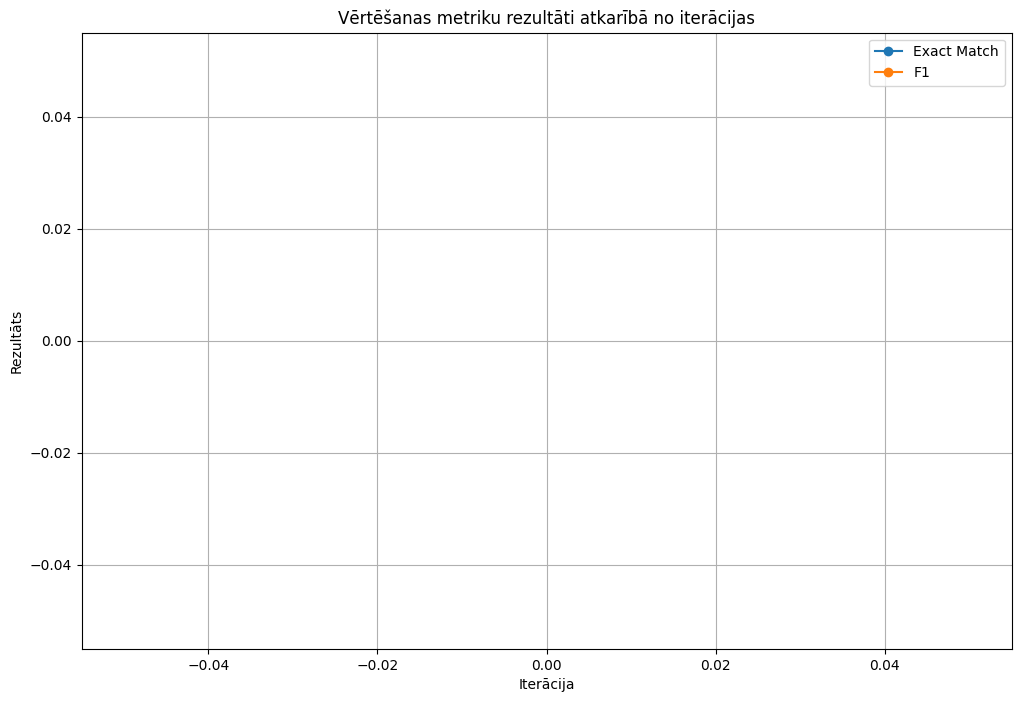

In [ ]:
if FINE_TUNED:
    !wget model_link

    # Ielādējam saglabātos svarus
    model.load_state_dict(torch.load(file_name))

    # Pārbaudām CUDA pieejamību un uzstādām modeli uz atbilstošās ierīces
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Ieslēdzam validācijas režīmu
trainer.evaluate(val_dataset)
plot_metrics_history(metrics_history)